In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate

In [72]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,target,6_squared
0,236,488,16,221,382,97,-4.472136,0.107472,0,132,...,0.870542,1.962937,7.466666,11.547794,8.822916,9.046424,7.895535,11.010677,20.107472,20.0
1,386,206,357,232,1,198,7.810250,0.763713,1,143,...,7.168680,2.885415,12.413973,10.260494,10.091351,9.270888,3.173994,13.921871,61.763713,61.0
2,429,49,481,111,111,146,8.602325,0.651162,1,430,...,0.394970,8.160625,12.592059,8.937577,2.265191,11.255721,12.794841,12.080951,74.651162,74.0
3,414,350,481,370,208,158,8.306624,0.424645,1,340,...,6.416708,10.549814,11.456437,6.468099,2.519049,0.258284,9.317696,5.383098,69.424645,69.0
4,318,359,20,218,317,301,8.124038,0.767304,1,212,...,1.919999,2.268203,0.149421,4.105907,10.416291,6.816217,8.586960,4.512419,66.767304,66.0


# Data preprocessing

In [73]:
# Splitting Dataset
y_train = df_train.target
X_train = df_train.drop(columns='target')

X_test = df_test

In [74]:
# Feature scaling using StandardScaler
scaler = StandardScaler()

# Scaling training dataset
columns = X_train.columns
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=columns)

# Scaling test dataset
columns = X_test.columns
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=columns)

# Scaling target variable
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_train_scaled = np.squeeze(y_train_scaled)

# Feature selection

After Data Analysis step we have discovered, that only feature 6_squared has a strong correlation with target feature. </br>
Now let's fit simple Linear Regression and check features importance

R2 Score:  1.0
RMSE:  2.2654983350115936e-15


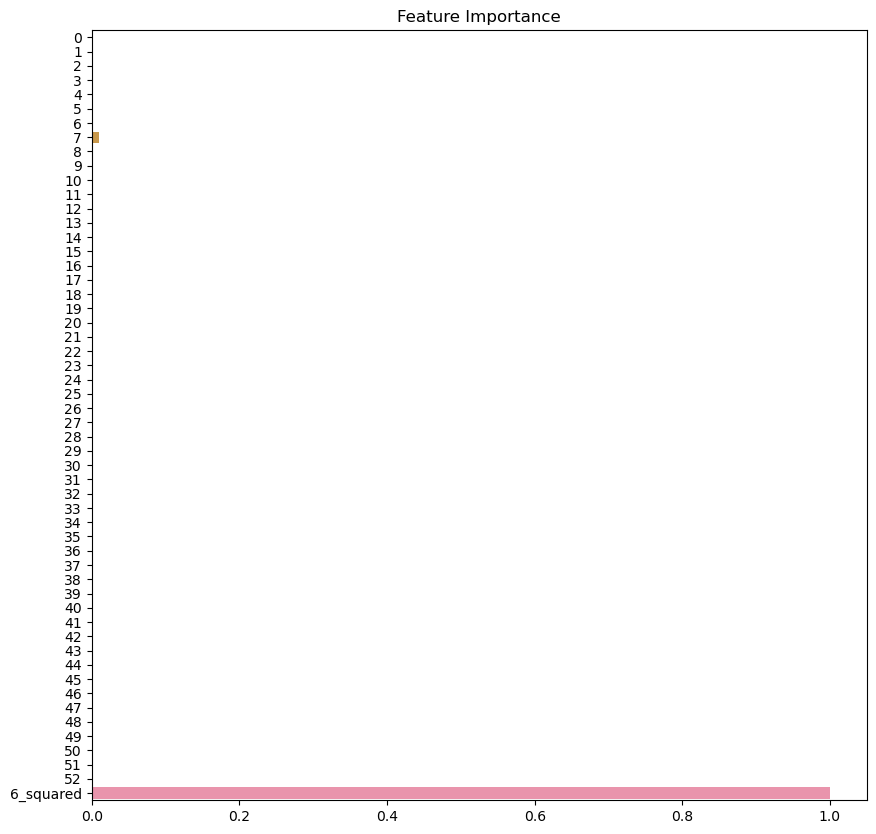

In [75]:
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)

importance = model.coef_
feature_names = model.feature_names_in_

# evaluating model
y_pred = model.predict(X_train_scaled)
print("R2 Score: ", r2_score(y_train_scaled, y_pred))
print("RMSE: ", np.sqrt(mean_squared_error(y_train_scaled, y_pred)))

# Plotting feature importance
plt.figure(figsize=(10, 10))
sns.barplot(x=importance, y=feature_names)
plt.title("Feature Importance")
plt.show()


As it was expected, feature 6_squared has a very big importance. </br>
But it also turned out, that feature 7 has a very little impact on prediction. We will use these 2 features for Regression

In [76]:
X_train_scaled_subset = X_train_scaled[["6_squared", "7"]]
X_test_scaled_subset = X_test_scaled[["6_squared", "7"]]

In [77]:
# Selecting Best Regressor
regressors = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "Decision_Tree": DecisionTreeRegressor()
}

results = pd.DataFrame(columns=["Regressor", "Avg_RMSE", "Avg_r2"])
for name, reg in regressors.items():
    model = reg
    cv_results = cross_validate(
        model, X_train_scaled_subset, y_train_scaled, cv=10,
        scoring=('r2', 'neg_root_mean_squared_error')
    )

    results = results.append({
        "Regressor": name,
        "Avg_RMSE": np.abs(cv_results['test_neg_root_mean_squared_error']).mean(),
        "Avg_r2": cv_results['test_r2'].mean()
    }, ignore_index=True)

results = results.sort_values("Avg_RMSE", ascending=True)
results.reset_index(drop=True)

C:\Users\nazar\AppData\Local\Temp\ipykernel_11688\2229751444.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
C:\Users\nazar\AppData\Local\Temp\ipykernel_11688\2229751444.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
C:\Users\nazar\AppData\Local\Temp\ipykernel_11688\2229751444.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
C:\Users\nazar\AppData\Local\Temp\ipykernel_11688\2229751444.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


,Regressor,Avg_RMSE,Avg_r2
0,Linear Regression,1.615589e-15,1.000000
1,Ridge,1.234517e-05,1.000000
2,Decision_Tree,3.010039e-05,1.000000
3,Lasso,9.994857e-01,0.000936


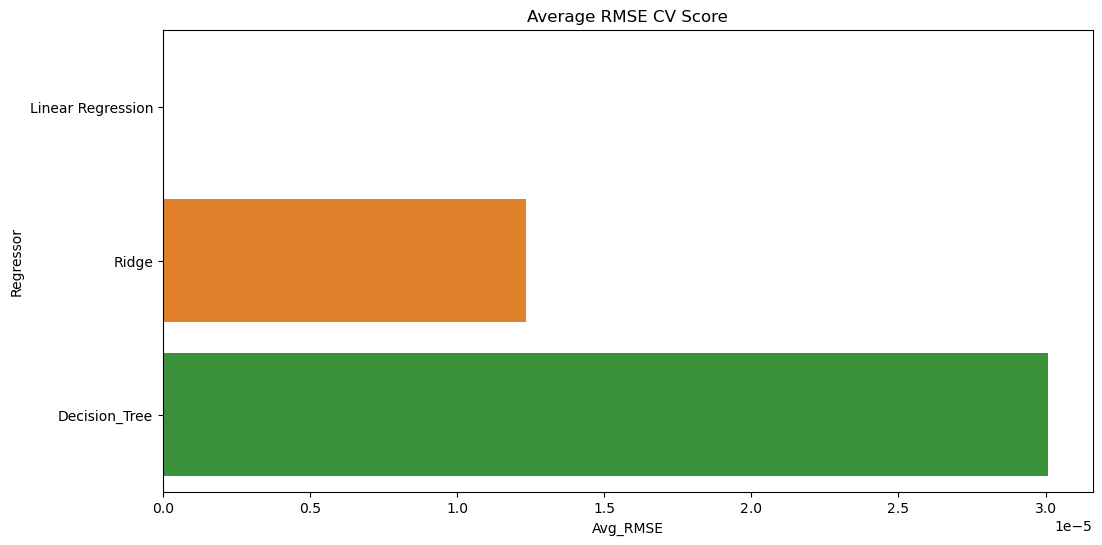

In [78]:
plt.figure(figsize=(12, 6))
sns.barplot(data=results.iloc[:-1, :], x="Avg_RMSE", y="Regressor")
plt.title("Average RMSE CV Score")
plt.show()

Linear Regression showed the best result. Lets use this model for predictions

In [79]:
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)

y_pred = model.predict(X_train_scaled)
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train_scaled, y_pred))}")

Train RMSE: 2.2654983350115936e-15


# Making submission

In [80]:
# Making prediction
y_pred_scaled = model.predict(X_test_scaled)

# Unscaling predicted values
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(1, -1)).reshape(1, -1)[0]

submission = pd.Series(data=y_pred, name="target")
submission.to_csv('predicted.csv', index=False)